# <center> Music Recommender System </center>
<img src = "music.png">

### Importing important libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


### Importing Datasets

In [6]:
df1 = pd.read_csv("songs.csv")
df2 = pd.read_csv("users.csv")

### Viewing Dataset

In [7]:
df1.head()

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0


In [8]:
df2.head()

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1


### Converting Year & Count to integer

In [9]:
df1["year"] = df1["year"].astype('Int64')
df2["listen_count"] = df2["listen_count"].astype('Int64')

### Merging both the datasets

In [10]:
df = pd.merge(df2, df1.drop_duplicates(["song_id"]), on='song_id', how='left')
df['song'] = df['artist_name'] + ' - ' + df['title']
df = df.drop(['title'], axis=1)
df.head()

,user_id,song_id,listen_count,release,artist_name,year,song
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,Thicker Than Water,Jack Johnson,0,Jack Johnson - The Cove
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Flamenco Para Niños,Paco De Lucia,1976,Paco De Lucia - Entre Dos Aguas
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Graduation,Kanye West,2007,Kanye West - Stronger
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,In Between Dreams,Jack Johnson,2005,Jack Johnson - Constellations
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,There Is Nothing Left To Lose,Foo Fighters,1999,Foo Fighters - Learn To Fly


In [11]:
df.count()

user_id         2000000
song_id         2000000
listen_count    2000000
release         2000000
artist_name     2000000
year            2000000
song            2000000
dtype: int64

### Exploratory data analysis

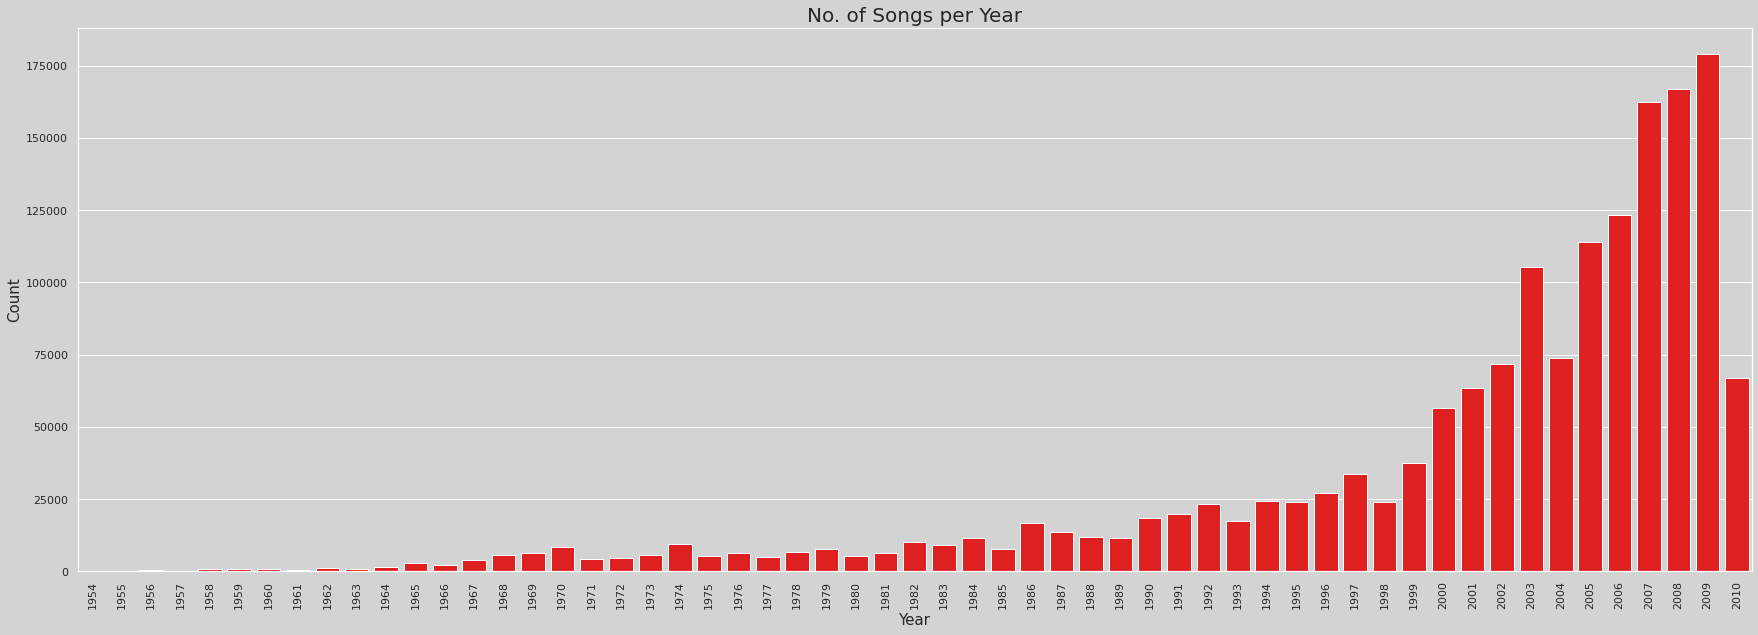

In [14]:
plt.figure(figsize=(30, 10))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'})
sns.countplot(x='year', data=df[-(df['year']==0)], color="red")
plt.xticks(rotation=90)
plt.title("No. of Songs per Year",fontsize=20)
plt.xlabel("Year", fontsize=15)
plt.ylabel("Count", fontsize=15)
plt.show()

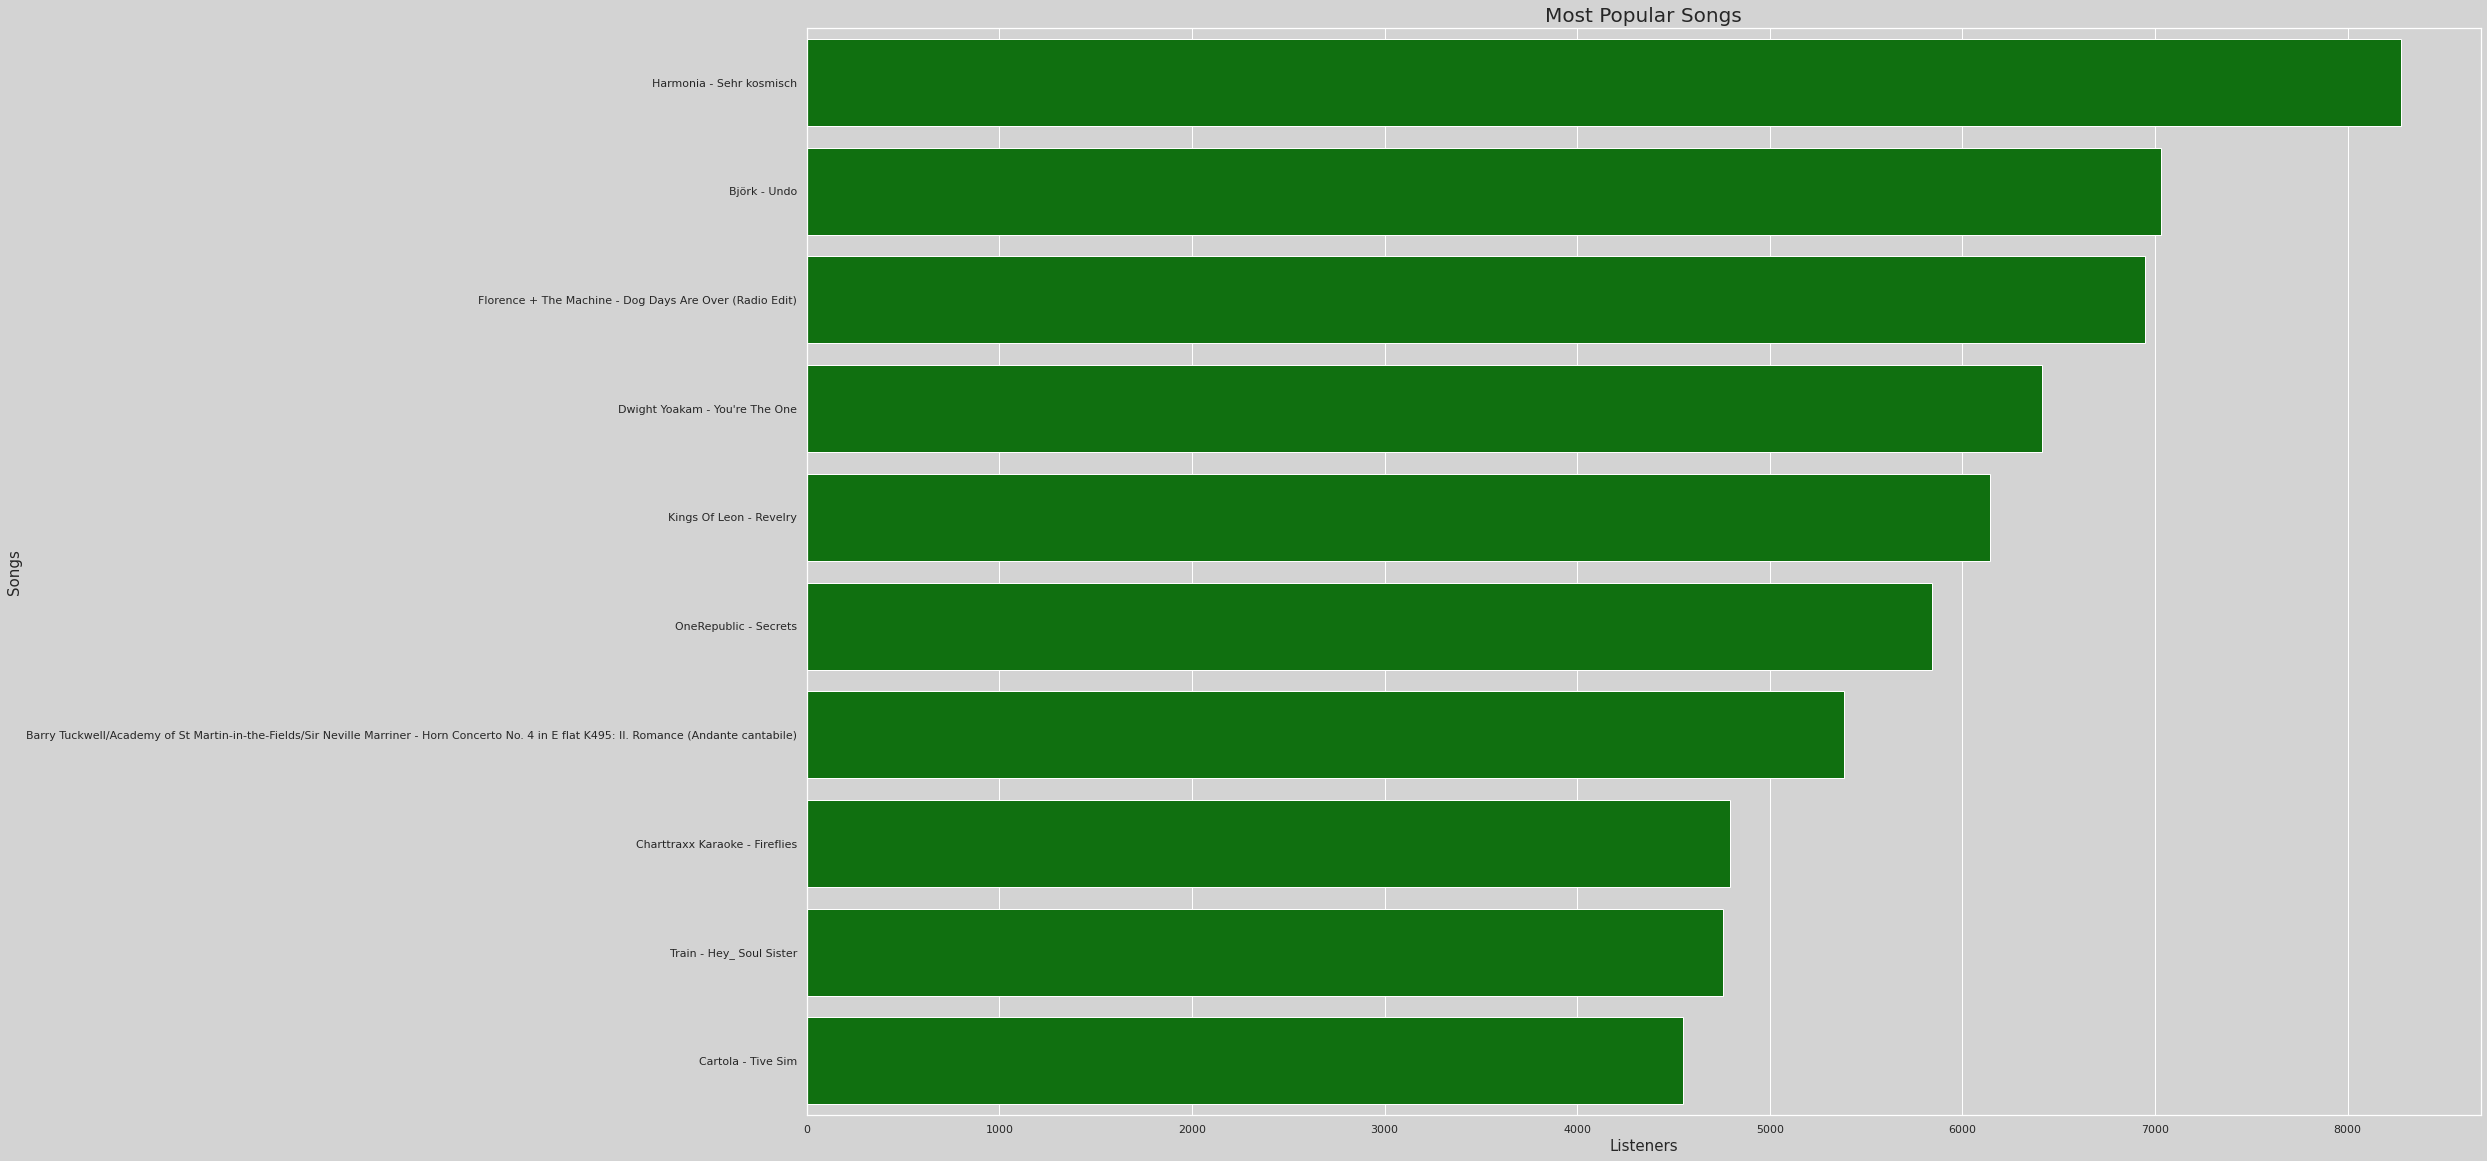

In [17]:
plt.figure(figsize=(30,20))
sns.set(rc={'axes.facecolor':'lightgrey', 'figure.facecolor':'lightgrey'})
sns.barplot(x = (df['song'].value_counts()[:10].values), y = (df['song'].value_counts()[:10].index), color="green")
plt.title('Most Popular Songs', fontsize=20)
plt.xlabel('Listeners', fontsize=15)
plt.ylabel('Songs', fontsize=15)
plt.show()

### Recommender System

In [29]:
df = df.head(50000)
class Engine():
    def __init__(self, data, user_id, song):
        self.data = data
        self.user_id = user_id
        self.song = song
        self.glcm = None
        
    def get_song_history(self, user):
        user_data = self.data[self.data[self.user_id] == user]
        return list(user_data[self.song].unique())
        
    def get_users(self, item):
        item_data = self.data[self.data[self.song] == item]
        return set(item_data[self.user_id].unique())
        
    def get_all_songs(self):
        return list(self.data[self.song].unique())
        
    def get_glcm(self, user_songs, all_songs):
        users = []        
        for i in range(0, len(user_songs)):
            users.append(self.get_users(user_songs[i]))   
        glcm = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)

        for i in range(0,len(all_songs)):
            songs_i_data = self.data[self.data[self.song] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):           
                users_j = users[j]
                users_intersection = users_i.intersection(users_j)
               
                users_union = users_i.union(users_j)
                glcm[j,i] = float(len(users_intersection))/float(len(users_union))

        return glcm

    def generate_recommendations(self, user, glcm, all_songs, user_songs):
        sim_scores = glcm.sum(axis=0)/float(glcm.shape[0])
        sim_scores = np.array(sim_scores)[0].tolist()
 
        sort_index = sorted(((e,i) for i,e in enumerate(list(sim_scores))), reverse=True)
        columns = ['UserID', 'Song', 'Score', 'Rank']
        df = pd.DataFrame(columns=columns)
         
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        print("Music Recommendations: \n")
        return df.drop(['UserID'], axis=1)

    def get_recommendations(self, user):
        user_songs = self.get_song_history(user)    
        all_songs = self.get_all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate_recommendations(user, glcm, all_songs, user_songs)

    def get_similar_songs(self, item_list):
        user_songs = item_list
        all_songs = self.get_all_songs()
        glcm = self.get_glcm(user_songs, all_songs)
        return self.generate_recommendations("", glcm, all_songs, user_songs)

### Getting Recommendations for specific user

In [30]:
eng = Engine(df, 'user_id', 'song')

In [31]:
song_history = eng.get_song_history(df['user_id'][1111])
for song in song_history:
  print(song)

Pixies - Where Is My Mind?
Charttraxx Karaoke - Jailbreak
Gorillaz - M1 A1
Avril Lavigne - When You're Gone
Metallica - Hit The Lights
Calle 13 - La Aguacatona
Talk Talk - It's My Life
Amy Winehouse - Love Is A Losing Game
Calle 13 - Tengo Hambre
Gorillaz - Left Hand Suzuki Method
Calle 13 - Atrévete te te
Amos Lee - Black River
Simple Minds - Oh Jungleland
Calle 13 - Cabe-c-o
Prince Alla - I Don't Want To Be Late
Phish - Billy Breathes
The Strokes - New York City Cops
Calle 13 - Electro Movimiento
Calle 13 Feat. Rubén Blades Y La Chilinga - La Perla
The Archies - Sugar Sugar
Metallica - The Four Horsemen
Binary Star - Solar Powered
Calle 13 Featuring Café Tacuba - No Hay Nadie Como Tú
Calle 13 - Fiesta De Locos
Calle 13 - La Fokin Moda
Calle 13 - Pi-di-di-di
Calle 13 Featuring Tego Calderón - Sin Exagerar
Calle 13 - Un Beso de Desayuno


### Get similar songs to a specified song

In [33]:
eng.get_similar_songs(['The Archies - Sugar Sugar'])

Music Recommendations: 



,Song,Score,Rank
0,Modest Mouse - Never Ending Math Equation,0.200000,1
1,Chaka Demus & Pliers - Murder She Wrote,0.200000,2
2,Richard Marx & Donna Lewis - At The Beginning ...,0.166667,3
3,Josh Turner - I Wouldn't Be A Man,0.166667,4
4,Blake Shelton - Ol' Red (Album Version),0.166667,5
5,Chris Cagle - What A Beautiful Day,0.166667,6
6,Ulrich Schnauss - Goodbye,0.166667,7
7,Deana Carter - Strawberry Wine,0.166667,8
8,Blake Shelton - She Wouldn't Be Gone (Album Ve...,0.166667,9
9,The Album Leaf - The Outer Banks,0.166667,10
